# lastfm-360k data_analysis

In [2]:
# Step 1: import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

user_df = pd.read_csv('atomic_datasets/lastfm-360k/lastfm-360k.user', sep='\t')
inter_df = pd.read_csv('atomic_datasets/lastfm-360k/lastfm-360k.inter', sep='\t')

print(user_df.nunique())
print(inter_df.nunique())
print(f"Before filtering {inter_df.shape}")

user_id:token    359347
gender:token          2
age:float           113
country:token       239
dtype: int64
user_id:token      359349
artist_id:token    160167
plays:float         14168
dtype: int64
Before filtering (17559530, 3)


In [3]:
print(user_df['country:token'].value_counts().head(20))

country:token
United States         67044
Germany               31651
United Kingdom        29902
Poland                20987
Russian Federation    19833
Brazil                14534
Sweden                13122
Spain                 13051
Finland               11579
Netherlands            9650
Canada                 8679
France                 7529
Italy                  7525
Australia              7135
Japan                  6637
Turkey                 6452
Norway                 5155
Mexico                 4834
Czech Republic         4774
Ukraine                4396
Name: count, dtype: int64


In [4]:
selected_country = 'Netherlands'
user_sample_df = user_df[
    (user_df['country:token'] == selected_country) &
    (user_df['gender:token'].notna())
]

print(f"Selected users from {selected_country} with gender attributes: {user_sample_df.shape}")

Selected users from Netherlands with gender attributes: (8792, 4)


In [5]:
valid_user_ids = user_sample_df['user_id:token'].unique()
inter_sample_df = inter_df[
    (inter_df['user_id:token'].isin(valid_user_ids)) &
    (inter_df['artist_id:token'].notna())
]

In [6]:
print(f"Before removing duplicates: {inter_sample_df.shape}")
# aggregate plays for duplicate user-item pairs
inter_df_agg = inter_sample_df.groupby(['user_id:token', 'artist_id:token'], as_index=False)['plays:float'].sum()

print(f"After aggregation: {inter_df_agg.shape}")

Before removing duplicates: (434518, 3)
After aggregation: (434507, 3)


In [7]:
artist_play_count = inter_df_agg.groupby('artist_id:token')['plays:float'].sum()

# artist plays > 1  
active_artists = artist_play_count[artist_play_count > 1].index

original_artist_count = artist_play_count.shape[0]
filtered_artist_count = len(active_artists)

removed_artist_count = original_artist_count - filtered_artist_count

inter_df_agg_filtered = inter_df_agg[inter_df_agg['artist_id:token'].isin(active_artists)].copy()

print(f"After removing artists with only 1 play: {inter_df_agg_filtered.shape}")
print(f"Original artists: {original_artist_count}")
print(f"Remaining artists: {filtered_artist_count}")
print(f"Removed artists with only 1 play: {removed_artist_count}")

After removing artists with only 1 play: (434240, 3)
Original artists: 36344
Remaining artists: 36077
Removed artists with only 1 play: 267


In [8]:
#normalize plays for each user
inter_df_agg_filtered.loc[:, 'plays_user_norm:float'] = inter_df_agg_filtered.groupby('user_id:token')['plays:float'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1.0
)

In [9]:
inter_df_agg_filtered.to_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.inter', sep='\t',index=False)
print("Filtered interaction data written to 'lastfm-nl.inter'")

user_sample_df = user_sample_df.copy()
user_sample_df['gender:token'] = user_sample_df['gender:token'].str.upper()
user_sample_df.to_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.user',sep='\t',index=False)
print("Filtered user data written to 'lastfm-nl.user'")

Filtered interaction data written to 'lastfm-nl.inter'
Filtered user data written to 'lastfm-nl.user'


# analyze the filtered data

In [10]:
user_df = pd.read_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.user', sep='\t')
inter_df = pd.read_csv('../Post-processing/datasets/lastfm-nl/lastfm-nl.inter', sep='\t')

print(user_df.nunique())
print(inter_df.nunique())
print(inter_df.shape)

user_id:token    8792
gender:token        2
age:float          74
country:token       1
dtype: int64
user_id:token              8792
artist_id:token           36077
plays:float                3914
plays_user_norm:float    142720
dtype: int64
(434240, 4)


In [11]:
n_users = inter_df['user_id:token'].nunique()
n_items = inter_df['artist_id:token'].nunique()
n_interactions = inter_df.shape[0]
sparsity = 1 - (n_interactions / (n_users * n_items))
print(f"Number of interactions: {n_interactions}")
print(f"Dataset Sparsity: {sparsity:.4%}")

Number of interactions: 434240
Dataset Sparsity: 99.8631%


In [12]:
print("User Data:")
display(user_df.head())
print("Interaction Data:")
display(inter_df.head())

User Data:


,user_id:token,gender:token,age:float,country:token
0,0004de6c3c32daa599bd03a37ce2356d5e7cc23f,M,23.0,Netherlands
1,0007e26aafcfc0b6dcb87d7041583fbb7cced88a,F,19.0,Netherlands
2,0009f70b52e48eca23a446d8a6f8bd2663691c54,F,24.0,Netherlands
3,001078f2f557a1afd9b9618144fc0b442481fd13,M,19.0,Netherlands
4,00292157f9c4e4b11464e886f27fff42f1ff442d,M,27.0,Netherlands


Interaction Data:


,user_id:token,artist_id:token,plays:float,plays_user_norm:float
0,0004de6c3c32daa599bd03a37ce2356d5e7cc23f,00eeed6b-5897-4359-8347-b8cd28375331,214,0.154079
1,0004de6c3c32daa599bd03a37ce2356d5e7cc23f,024c3b90-9d09-4c67-902f-fdf49649e4f8,78,0.017120
2,0004de6c3c32daa599bd03a37ce2356d5e7cc23f,0383dadf-2a4e-4d10-a46a-e9e041da8eb3,73,0.012085
3,0004de6c3c32daa599bd03a37ce2356d5e7cc23f,07f59ab8-32ff-48ad-a9ff-866078e1a2d5,126,0.065458
4,0004de6c3c32daa599bd03a37ce2356d5e7cc23f,0c235ae9-7e9d-428f-b0af-3fa8dbb20064,79,0.018127


## 1. user_df data analysis

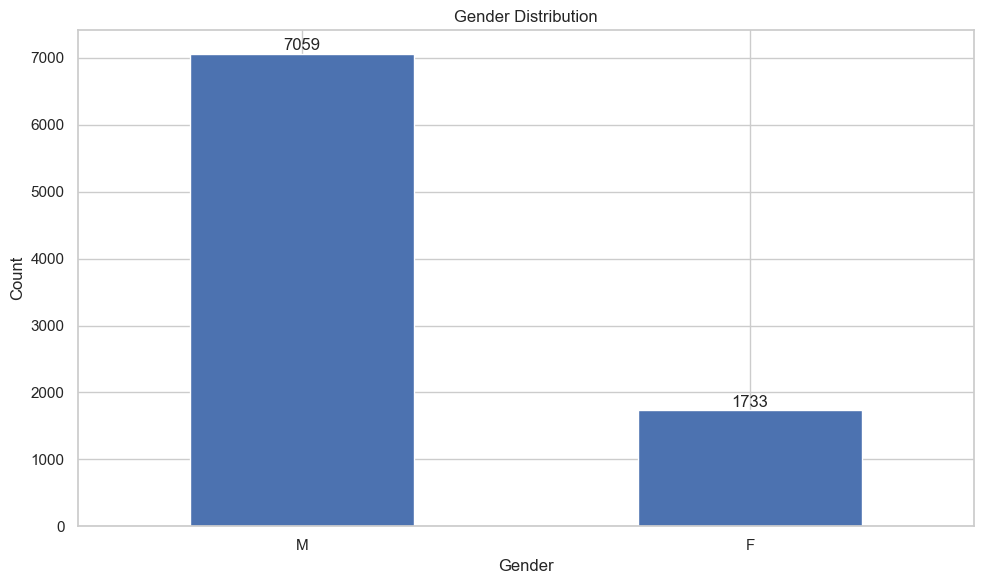

In [13]:
# gender distribution
gender_counts = user_df['gender:token'].value_counts()

# 绘制柱状图
ax = gender_counts.plot(kind='bar', title='Gender Distribution', rot=0)

# 添加每个柱子的数值标签
for i, count in enumerate(gender_counts):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

# 展示图形
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

User Activity Statistics:
         total_plays
count    8792.000000
mean    10042.393995
std     13239.124643
min        18.000000
25%      2588.250000
50%      6273.000000
75%     12756.750000
max    274757.000000


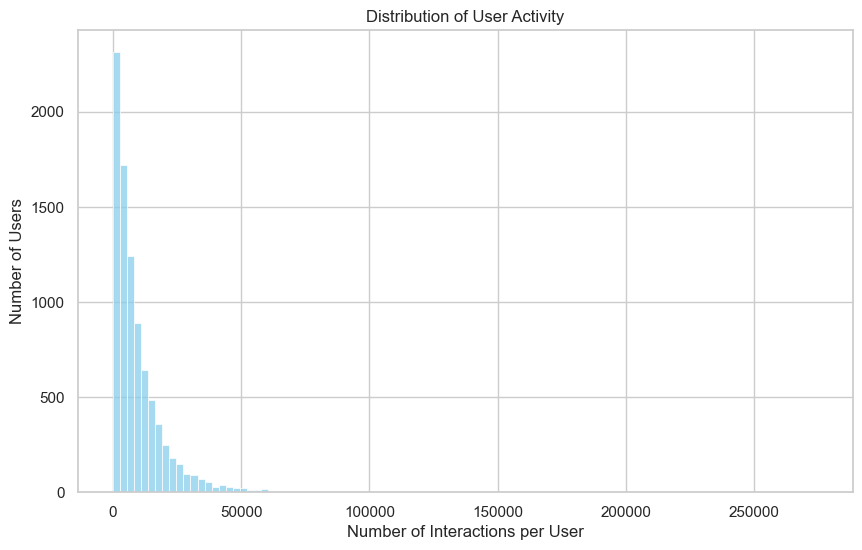

In [14]:
# user activity distribution plays
user_activity = inter_df.groupby('user_id:token')['plays:float'].sum().reset_index()

print("User Activity Statistics:")
user_activity.columns = ['user_id', 'total_plays']
print(user_activity.describe())

plt.figure(figsize=(10, 6))
sns.histplot(user_activity['total_plays'], bins=100, kde=False, color='skyblue')
plt.title("Distribution of User Activity")
plt.xlabel("Number of Interactions per User")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

User Activity Statistics:
       total_plays_norm
count       8792.000000
mean           8.227267
std            3.582304
min            1.000000
25%            5.656873
50%            7.810373
75%           10.311509
max           28.657895


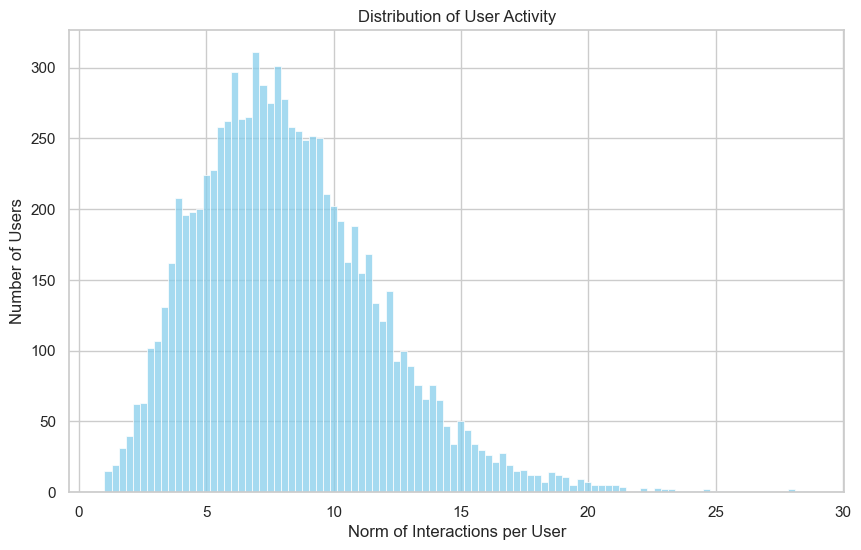

In [15]:
# user activity distribution plays_user_norm
user_activity = inter_df.groupby('user_id:token')['plays_user_norm:float'].sum().reset_index()

print("User Activity Statistics:")
user_activity.columns = ['user_id', 'total_plays_norm']
print(user_activity.describe())

plt.figure(figsize=(10, 6))
sns.histplot(user_activity['total_plays_norm'], bins=100, kde=False, color='skyblue')
plt.title("Distribution of User Activity")
plt.xlabel("Norm of Interactions per User")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

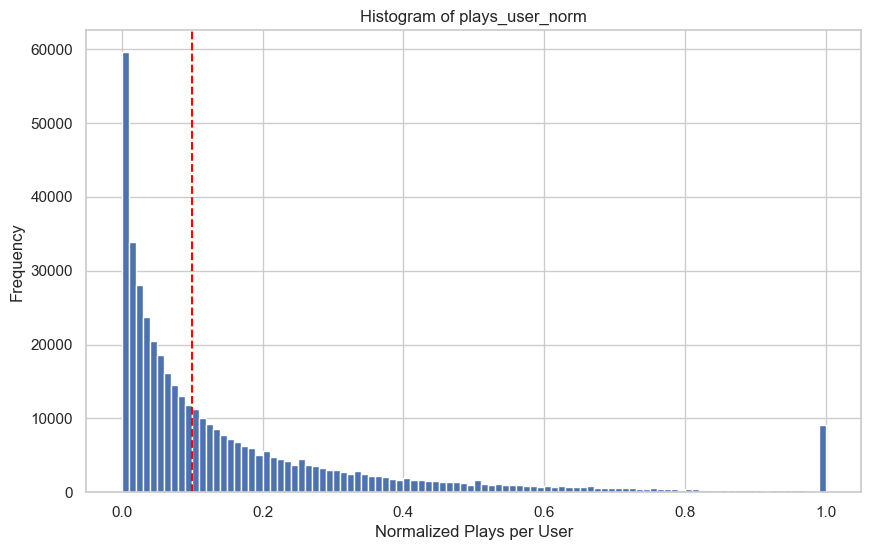

In [16]:
plt.hist(inter_df['plays_user_norm:float'], bins=100)
plt.axvline(x=0.1, color='red', linestyle='--')
plt.title("Histogram of plays_user_norm")
plt.xlabel("Normalized Plays per User")
plt.ylabel("Frequency")
plt.show()

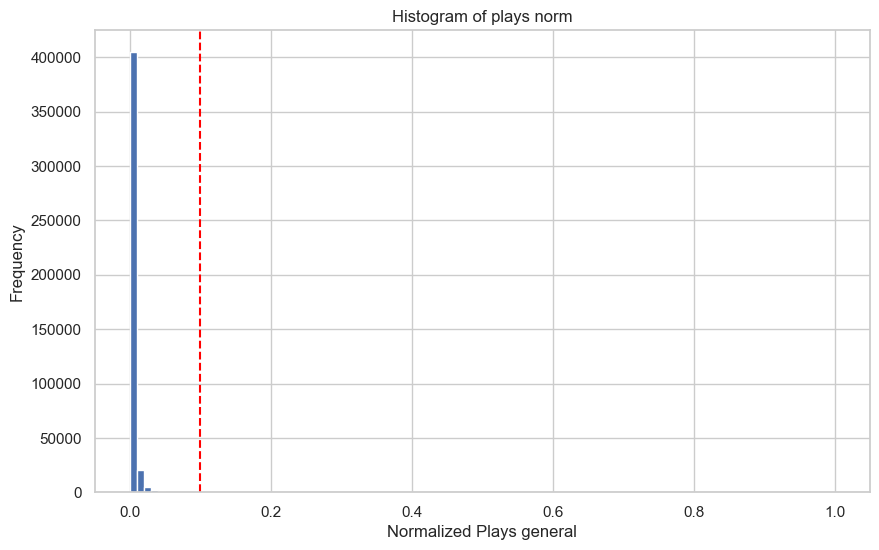

In [17]:
min_play = inter_df['plays:float'].min()
max_play = inter_df['plays:float'].max()
inter_df.loc[:, 'plays_norm:float'] = (inter_df['plays:float'] - min_play) / (max_play - min_play)

plt.hist(inter_df['plays_norm:float'], bins=100)
plt.axvline(x=0.1, color='red', linestyle='--')
plt.title("Histogram of plays norm")
plt.xlabel("Normalized Plays general")
plt.ylabel("Frequency")
plt.show()

Item Popularity Statistics:
count    36077.000000
mean        12.036478
std         55.314267
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       2400.000000
Name: count, dtype: float64


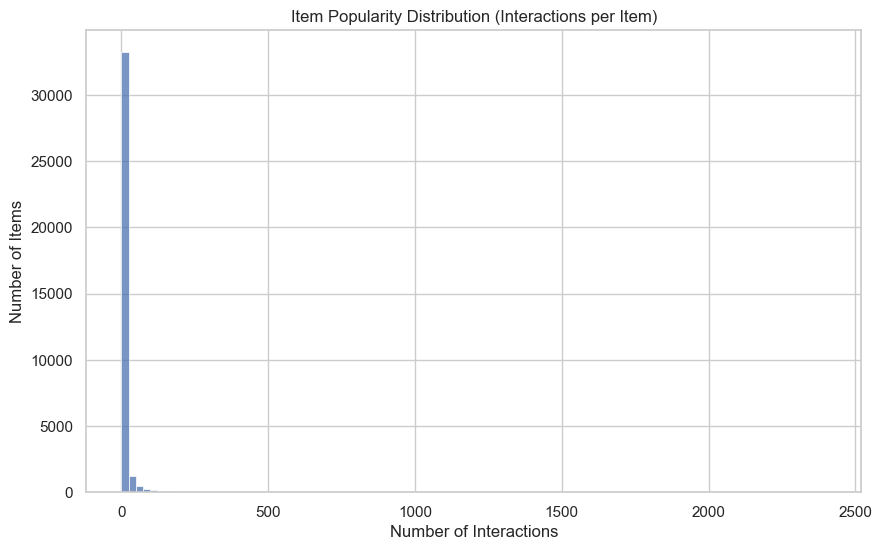

In [18]:
item_popularity = inter_df['artist_id:token'].value_counts()
print("Item Popularity Statistics:")
print(item_popularity.describe())

sns.histplot(item_popularity, bins=100, kde=False)
plt.title('Item Popularity Distribution (Interactions per Item)')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Items')
plt.show() 

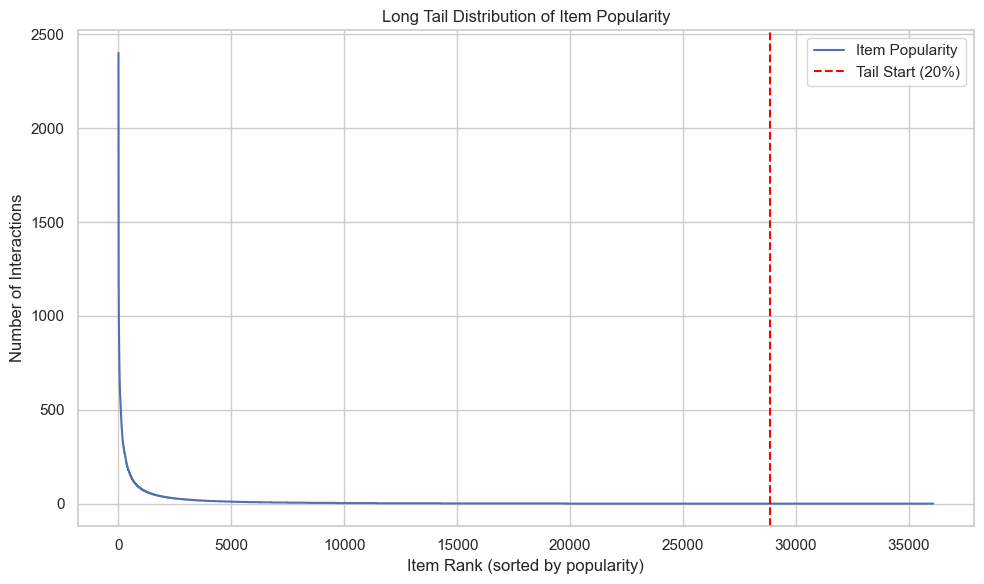

In [19]:
# Calculate item popularity
item_popularity = inter_df['artist_id:token'].value_counts()

# Sort popularity in descending order
sorted_popularity = item_popularity.sort_values(ascending=False).reset_index(drop=True)

tail_ratio = 0.2
tail_index = int(len(sorted_popularity) * (1 - tail_ratio))

# Plot: Long-tail with tail cutoff
plt.figure(figsize=(10, 6))
plt.plot(sorted_popularity.values, label='Item Popularity')
plt.axvline(x=tail_index, color='red', linestyle='--', label=f'Tail Start ({int(tail_ratio*100)}%)')
plt.title('Long Tail Distribution of Item Popularity')
plt.xlabel('Item Rank (sorted by popularity)')
plt.ylabel('Number of Interactions')
#plt.yscale('log')  # Optional: log scale for better visibility of tail
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()